In [33]:
import torch
from torch import nn,optim
import functools
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.utils as vutils

In [34]:
import random
import numpy as np
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
from skimage.transform import resize

In [35]:
from tensorboardX import SummaryWriter
writer=SummaryWriter('/user1/faculty/cvpr/ujjwal/dhritimaan/GANs/datasets/log_cycle_gan/')

In [36]:
class SequenceFolder(data.Dataset):
    def __init__(self, trainA,trainB):
        self.trainA=trainA
        self.trainB=trainB

    def __len__(self):
        return 1556
    def __getitem__(self, index):
        index_a=index%len(self.trainA)
        index_b=index%len(self.trainB)
        imgA=plt.imread(self.trainA[index_a])
        imgB=plt.imread(self.trainB[index_b])
        imgA=resize(imgA,(256,256,3))
        imgB=resize(imgB,(256,256,3))
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
        #index=index%
        dict_img={'A':imgA,'B':imgB}
        return dict_img

In [37]:
#plt.imread(foggy_paths[0]).shape
import os

In [38]:
file1 = open("/user1/faculty/cvpr/ujjwal/kaiser/dataset/foggy_zurich/Foggy_Zurich/lists_file_names/RGB_medium_filenames.txt",
             "r")
x=file1.read()
foggy_paths=[os.path.join('/user1/faculty/cvpr/ujjwal/kaiser/dataset/foggy_zurich/Foggy_Zurich',t) for t in x.splitlines()]

In [39]:


import os
city=os.listdir('/user1/faculty/cvpr/ujjwal/kaiser/dataset/cityscape/leftImg8bit/train')

In [40]:

img_paths=[]
for i in range(10):
    city_path=os.path.join('/user1/faculty/cvpr/ujjwal/kaiser/dataset/cityscape/leftImg8bit/train',city[i])
    img_names=os.listdir(city_path)
    k=[os.path.join(city_path,s) for s in img_names]
    for j in range(len(k)):
        img_paths.append(k[j])

In [41]:
#foggy_paths

In [42]:
train=SequenceFolder(foggy_paths,img_paths)#lista,listb)

In [43]:
dataloader=torch.utils.data.DataLoader(train,batch_size=3,shuffle=True)

In [44]:
import matplotlib.pyplot as plt
for a,b in enumerate(dataloader):
    a
    break

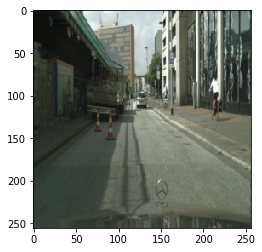

In [45]:
import matplotlib.pyplot as plt
plt.imshow(b['B'][0])

In [46]:
b['B'].permute(0,3,1,2).shape

torch.Size([3, 3, 256, 256])

In [47]:
#torch.cat((b['A'].permute(0,3,1,2),b['B'].permute(0,3,1,2)),1).shape

In [48]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [49]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [50]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [51]:
#os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(str(x) for x in [0,1,2])
cuda=torch.device('cuda:1')
#device_ids=opt.gpus
genAB=ResnetGenerator(3,3).to(cuda)
genBA=ResnetGenerator(3,3).to(cuda)

In [52]:
discAB=NLayerDiscriminator(3).to(cuda)
discBA=NLayerDiscriminator(3).to(cuda)

In [53]:
from itertools import chain

In [54]:
gen_optim=optim.Adam(chain(genAB.parameters(),genBA.parameters()),lr=0.0002,betas=(0.5,0.999))
dis_optim=optim.Adam(chain(discAB.parameters(),discBA.parameters()),lr=0.0002,betas=(0.5,0.999))

In [55]:
#loss_ce=nn.NLLLoss()
loss_mse=nn.MSELoss()
#loss_rec=l1loss()

In [56]:
def l1loss(x,y):
    return torch.mean(torch.abs(x-y))
def mse(x,y):
    return torch.mean((x-y)**2)

In [57]:
#nn.L1Loss()
import skimage

In [58]:
from skimage.transform import resize

In [59]:
#genAB(torch.cat((b['A'],b['A']),1).permute(0,3,1,2).float().to(cuda)/255)
import pytorch_ssim
ssim_loss=pytorch_ssim.SSIM()

In [ ]:
num_epochs=100
count=0
for epoch in range(num_epochs):
    for n_batches,real_data in enumerate(dataloader):
        realA=real_data['A'].permute(0,3,1,2).float().to(cuda)
        realB=real_data['B'].permute(0,3,1,2).float().to(cuda)
        
        
        #realA=torch.cat((realA_,realA_),1)
        #realB=torch.cat((realA_,realB_),1)
        
        
        fakeB=genAB(realA)
        fakeA=genBA(realB)
        recA=genBA(fakeB)
        recB=genAB(fakeA)
        dis_real_labB=discAB(realB)
        dis_fake_labB=discAB(fakeB)
        dis_real_labA=discBA(realA)
        dis_fake_labA=discBA(fakeA)
        dis_rec_labA=discBA(recA)
        dis_rec_labB=discAB(recB)
        
        ssim_loss_a=ssim_loss(realA,fakeB)
        ssim_loss_b=ssim_loss(realB,fakeA)
        
        gen_optim.zero_grad()
        #######training generators
        error_genAB=loss_mse(dis_fake_labB,Variable(torch.ones(realA.shape[0],1,30,30).to(cuda)))
        error_genBA=loss_mse(dis_fake_labA,Variable(torch.ones(realA.shape[0],1,30,30).to(cuda)))
        rec_errorA=l1loss(recA,realA)#loss_rec(recA,realA)
        rec_errorB=l1loss(recB,realB)#loss_rec(recB,realB)
                            
        g_loss=error_genAB+error_genBA+10*rec_errorA+10*rec_errorB-ssim_loss_b-ssim_loss_a
        #error_genAB.backward(retain_graph=True)
        #error_genBA.backward()
        #rec_errorA.backward()
        #rec_errorB.backward()
        g_loss.backward()#retain_graph=True)
        
        gen_optim.step()
                            
                            
        #########training discrminators
        dis_optim.zero_grad()
        
        
        fakeB=genAB(realA)
        fakeA=genBA(realB)
        recA=genBA(fakeB)
        recB=genAB(fakeA)
        dis_real_labB=discAB(realB)
        dis_fake_labB=discAB(fakeB)
        dis_real_labA=discBA(realA)
        dis_fake_labA=discBA(fakeA)
        dis_rec_labA=discBA(recA)
        dis_rec_labB=discAB(recB)

        
        
        error_discAB_with_realB=loss_mse(dis_real_labB,Variable(torch.ones(realA.shape[0],1,30,30).to(cuda)))
        error_discAB_with_fakeB=loss_mse(dis_fake_labB,Variable(torch.zeros(realA.shape[0],1,30,30).to(cuda)))
        error_discBA_with_realA=loss_mse(dis_real_labA,Variable(torch.ones(realA.shape[0],1,30,30).to(cuda)))
        error_discBA_with_fakeA=loss_mse(dis_fake_labA,Variable(torch.zeros(realA.shape[0],1,30,30).to(cuda)))
        
        disc_loss=error_discAB_with_realB+error_discAB_with_fakeB+error_discBA_with_realA+error_discBA_with_fakeA
        disc_loss.backward()
        #error_discAB_with_fakeB.backward()
        #error_discBA_with_realB.backward()
        #error_discBA_with_realB.backward()
        if count%10==0:
            writer.add_image("realA",vutils.make_grid(realA,padding=2,normalize=True),count)
            writer.add_image("realB",vutils.make_grid(realB,padding=2,normalize=True),count)
            writer.add_image("fakeA",vutils.make_grid(fakeA,padding=2,normalize=True),count)
            writer.add_image("fakeB",vutils.make_grid(fakeB,padding=2,normalize=True),count)
            writer.add_image("recA",vutils.make_grid(recA,padding=2,normalize=True),count)
            writer.add_image("recB",vutils.make_grid(recB,padding=2,normalize=True),count)
            
            writer.add_scalar("d_loss",disc_loss.item(),count)
            writer.add_scalar("g_loss",g_loss.item(),count)
            writer.add_scalar("dis_real_labB",dis_real_labB.mean(),count)
            writer.add_scalar("dis_fake_labB",dis_real_labB.mean(),count)
            writer.add_scalar("dis_real_labA",dis_real_labB.mean(),count)
            writer.add_scalar("dis_fake_labB",dis_real_labB.mean(),count)
            writer.add_scalar("dis_rec_labA",dis_real_labB.mean(),count)
            writer.add_scalar("dis_rec_labB",dis_real_labB.mean(),count)
            
            
            #writer.add_scalar("")
        
        dis_optim.step()
        
        count=count+1
        print("epoch:{}  disc_loss:{}  gen_loss:{} recA Loss:{} recB Loss:{}".format(epoch,disc_loss,g_loss,rec_errorA
                                                                                     ,rec_errorB))

epoch:0  disc_loss:2.112884283065796  gen_loss:10.199019432067871 recA Loss:0.5555539727210999 recB Loss:0.2862776815891266
epoch:0  disc_loss:10.410472869873047  gen_loss:8.577651023864746 recA Loss:0.36585235595703125 recB Loss:0.18840713798999786
epoch:0  disc_loss:7.974545001983643  gen_loss:8.222979545593262 recA Loss:0.2642282545566559 recB Loss:0.18690398335456848
epoch:0  disc_loss:1.538726806640625  gen_loss:4.576320171356201 recA Loss:0.20713312923908234 recB Loss:0.1702883541584015
epoch:0  disc_loss:1.636476993560791  gen_loss:4.126412868499756 recA Loss:0.16295777261257172 recB Loss:0.16007378697395325
epoch:0  disc_loss:1.4842426776885986  gen_loss:3.4361119270324707 recA Loss:0.11978486180305481 recB Loss:0.11341682821512222
epoch:0  disc_loss:1.0916889905929565  gen_loss:3.0560595989227295 recA Loss:0.1110868826508522 recB Loss:0.11004568636417389
epoch:0  disc_loss:1.1452066898345947  gen_loss:3.0689144134521484 recA Loss:0.10145514458417892 recB Loss:0.132694676518440

epoch:0  disc_loss:0.9366400241851807  gen_loss:1.4199903011322021 recA Loss:0.059363916516304016 recB Loss:0.07775364071130753
epoch:0  disc_loss:0.8136259317398071  gen_loss:1.483741044998169 recA Loss:0.05571221187710762 recB Loss:0.09068439155817032
epoch:0  disc_loss:0.7267904877662659  gen_loss:0.6774742603302002 recA Loss:0.05447005107998848 recB Loss:0.05311732366681099
epoch:0  disc_loss:0.8647361993789673  gen_loss:1.470467448234558 recA Loss:0.052905745804309845 recB Loss:0.13998229801654816
epoch:0  disc_loss:0.5868023037910461  gen_loss:0.8198962211608887 recA Loss:0.06332278251647949 recB Loss:0.06210312619805336
epoch:0  disc_loss:0.6608811616897583  gen_loss:1.5885734558105469 recA Loss:0.09973430633544922 recB Loss:0.09137722104787827
epoch:0  disc_loss:0.5688470005989075  gen_loss:1.0560133457183838 recA Loss:0.0535661019384861 recB Loss:0.08682463318109512
epoch:0  disc_loss:0.49303460121154785  gen_loss:0.835183322429657 recA Loss:0.05501411855220795 recB Loss:0.065

epoch:0  disc_loss:0.40577057003974915  gen_loss:1.1484488248825073 recA Loss:0.05025167763233185 recB Loss:0.0647420883178711
epoch:0  disc_loss:0.5283712148666382  gen_loss:2.0921359062194824 recA Loss:0.0789521113038063 recB Loss:0.08806625753641129
epoch:0  disc_loss:0.6826760768890381  gen_loss:1.402025580406189 recA Loss:0.04869591072201729 recB Loss:0.06811632215976715
epoch:0  disc_loss:0.5573734045028687  gen_loss:1.6926887035369873 recA Loss:0.06619005650281906 recB Loss:0.07584501802921295
epoch:0  disc_loss:0.4568525552749634  gen_loss:1.5881702899932861 recA Loss:0.08567261695861816 recB Loss:0.054103784263134
epoch:0  disc_loss:0.22478412091732025  gen_loss:1.477024793624878 recA Loss:0.04366369545459747 recB Loss:0.07339303195476532
epoch:0  disc_loss:0.4441174566745758  gen_loss:1.312389850616455 recA Loss:0.06208203360438347 recB Loss:0.05622684955596924
epoch:0  disc_loss:0.4787222445011139  gen_loss:1.555148720741272 recA Loss:0.09680146723985672 recB Loss:0.04620197

epoch:0  disc_loss:1.1387559175491333  gen_loss:1.5901427268981934 recA Loss:0.06623122841119766 recB Loss:0.047656089067459106
epoch:0  disc_loss:0.8447821140289307  gen_loss:1.3391945362091064 recA Loss:0.057450465857982635 recB Loss:0.05664777010679245
epoch:0  disc_loss:0.8544213175773621  gen_loss:1.4658894538879395 recA Loss:0.06249036267399788 recB Loss:0.0680757686495781
epoch:0  disc_loss:0.9759043455123901  gen_loss:0.7318101525306702 recA Loss:0.05305369570851326 recB Loss:0.04218485578894615
epoch:0  disc_loss:0.9039698243141174  gen_loss:1.3125945329666138 recA Loss:0.05821438506245613 recB Loss:0.05496824532747269
epoch:0  disc_loss:0.7983257174491882  gen_loss:1.9640233516693115 recA Loss:0.08003208786249161 recB Loss:0.060108285397291183
epoch:0  disc_loss:0.6332253813743591  gen_loss:1.4126873016357422 recA Loss:0.08041568100452423 recB Loss:0.06746915727853775
epoch:0  disc_loss:0.7584153413772583  gen_loss:1.3977993726730347 recA Loss:0.07467229664325714 recB Loss:0.

epoch:0  disc_loss:0.6246585249900818  gen_loss:1.0730140209197998 recA Loss:0.05811729654669762 recB Loss:0.05127446725964546
epoch:0  disc_loss:0.6428679823875427  gen_loss:1.555616855621338 recA Loss:0.05745904892683029 recB Loss:0.06589734554290771
epoch:0  disc_loss:0.6876909732818604  gen_loss:0.9538766741752625 recA Loss:0.054926685988903046 recB Loss:0.057401884347200394
epoch:0  disc_loss:0.6113390922546387  gen_loss:1.4774625301361084 recA Loss:0.06385540217161179 recB Loss:0.059992313385009766
epoch:0  disc_loss:0.553717315196991  gen_loss:1.20414400100708 recA Loss:0.050661634653806686 recB Loss:0.07807262241840363
epoch:0  disc_loss:0.8490728735923767  gen_loss:0.7422580122947693 recA Loss:0.0509706549346447 recB Loss:0.057929981499910355
epoch:0  disc_loss:0.8940158486366272  gen_loss:2.4974381923675537 recA Loss:0.06216336786746979 recB Loss:0.07521402090787888
epoch:0  disc_loss:1.3732548952102661  gen_loss:1.650268793106079 recA Loss:0.05823756009340286 recB Loss:0.055

epoch:0  disc_loss:0.7964483499526978  gen_loss:1.495215892791748 recA Loss:0.06457582116127014 recB Loss:0.07098140567541122
epoch:0  disc_loss:0.7563861012458801  gen_loss:1.9067957401275635 recA Loss:0.09955496340990067 recB Loss:0.05966966599225998
epoch:0  disc_loss:1.0874358415603638  gen_loss:0.5778699517250061 recA Loss:0.0573730543255806 recB Loss:0.042764876037836075
epoch:0  disc_loss:1.0059791803359985  gen_loss:0.8150673508644104 recA Loss:0.06438092142343521 recB Loss:0.06742707639932632
epoch:0  disc_loss:0.8481422662734985  gen_loss:0.5999800562858582 recA Loss:0.05922218784689903 recB Loss:0.04872294142842293
epoch:0  disc_loss:0.5006434917449951  gen_loss:1.0818818807601929 recA Loss:0.04360891878604889 recB Loss:0.07872874289751053
epoch:0  disc_loss:0.48587560653686523  gen_loss:1.860222339630127 recA Loss:0.08144421875476837 recB Loss:0.09878817945718765
epoch:0  disc_loss:0.6743667125701904  gen_loss:0.8261302709579468 recA Loss:0.05643993616104126 recB Loss:0.046

epoch:0  disc_loss:0.7008568048477173  gen_loss:0.6557771563529968 recA Loss:0.04196831211447716 recB Loss:0.050352953374385834
epoch:0  disc_loss:0.7596374750137329  gen_loss:0.7046067714691162 recA Loss:0.043731097131967545 recB Loss:0.07155206799507141
epoch:0  disc_loss:0.6591968536376953  gen_loss:1.0457278490066528 recA Loss:0.058046597987413406 recB Loss:0.06700118631124496
epoch:0  disc_loss:0.7834929823875427  gen_loss:0.92144376039505 recA Loss:0.042211782187223434 recB Loss:0.06137697026133537
epoch:0  disc_loss:0.8162981271743774  gen_loss:1.0477111339569092 recA Loss:0.055298976600170135 recB Loss:0.06593426316976547
epoch:0  disc_loss:0.6087798476219177  gen_loss:1.1876258850097656 recA Loss:0.06736317276954651 recB Loss:0.06918145716190338
epoch:0  disc_loss:0.6998857259750366  gen_loss:1.3158338069915771 recA Loss:0.057838015258312225 recB Loss:0.09333421289920807
epoch:0  disc_loss:0.6458897590637207  gen_loss:0.8248720169067383 recA Loss:0.04793429374694824 recB Loss:

epoch:0  disc_loss:0.7794328331947327  gen_loss:1.1963553428649902 recA Loss:0.0466284453868866 recB Loss:0.05388346314430237
epoch:0  disc_loss:0.7492655515670776  gen_loss:1.185206651687622 recA Loss:0.049568191170692444 recB Loss:0.0644601508975029
epoch:0  disc_loss:0.7732489109039307  gen_loss:1.2844419479370117 recA Loss:0.048913855105638504 recB Loss:0.05467561259865761
epoch:0  disc_loss:0.7674093842506409  gen_loss:0.8950504064559937 recA Loss:0.04436322674155235 recB Loss:0.05127248913049698
epoch:0  disc_loss:0.617377758026123  gen_loss:1.1194119453430176 recA Loss:0.06776831299066544 recB Loss:0.06663542240858078
epoch:0  disc_loss:0.6806223392486572  gen_loss:0.6552501916885376 recA Loss:0.044725075364112854 recB Loss:0.04663524776697159
epoch:0  disc_loss:0.8026214241981506  gen_loss:0.4212248921394348 recA Loss:0.047396332025527954 recB Loss:0.03501851111650467
epoch:0  disc_loss:0.7000622749328613  gen_loss:0.6975910663604736 recA Loss:0.041652508080005646 recB Loss:0.0

epoch:1  disc_loss:1.0020530223846436  gen_loss:0.6572840809822083 recA Loss:0.04885180667042732 recB Loss:0.04177512228488922
epoch:1  disc_loss:0.8731133937835693  gen_loss:1.4852795600891113 recA Loss:0.05563957244157791 recB Loss:0.05588997155427933
epoch:1  disc_loss:0.7913874387741089  gen_loss:0.5967035889625549 recA Loss:0.03819970041513443 recB Loss:0.07381286472082138
epoch:1  disc_loss:0.5589777827262878  gen_loss:1.2531545162200928 recA Loss:0.050844576209783554 recB Loss:0.05736805871129036
epoch:1  disc_loss:0.8949271440505981  gen_loss:1.1658425331115723 recA Loss:0.0533483512699604 recB Loss:0.09905290603637695
epoch:1  disc_loss:0.7719059586524963  gen_loss:0.5595718026161194 recA Loss:0.04269406199455261 recB Loss:0.05095537006855011
epoch:1  disc_loss:0.6825377345085144  gen_loss:1.1310045719146729 recA Loss:0.06279565393924713 recB Loss:0.04168881103396416
epoch:1  disc_loss:0.7537817358970642  gen_loss:0.6959850192070007 recA Loss:0.047584258019924164 recB Loss:0.0

epoch:1  disc_loss:0.9327000379562378  gen_loss:0.917003333568573 recA Loss:0.04759424924850464 recB Loss:0.07588371634483337
epoch:1  disc_loss:1.1154634952545166  gen_loss:0.8867138624191284 recA Loss:0.05288153886795044 recB Loss:0.05762552097439766
epoch:1  disc_loss:0.8346418142318726  gen_loss:1.1123065948486328 recA Loss:0.06179596856236458 recB Loss:0.09276015311479568
epoch:1  disc_loss:0.7382384538650513  gen_loss:0.4756010174751282 recA Loss:0.03901238739490509 recB Loss:0.06524708867073059
epoch:1  disc_loss:0.7914245128631592  gen_loss:1.263461709022522 recA Loss:0.05212196335196495 recB Loss:0.10876557230949402
epoch:1  disc_loss:0.8296350836753845  gen_loss:0.8210803866386414 recA Loss:0.05716024711728096 recB Loss:0.05467075854539871
epoch:1  disc_loss:0.970649003982544  gen_loss:0.8484134674072266 recA Loss:0.06051621958613396 recB Loss:0.07784851640462875
epoch:1  disc_loss:0.8761065006256104  gen_loss:0.7314416766166687 recA Loss:0.044513728469610214 recB Loss:0.0601

epoch:1  disc_loss:0.9001501202583313  gen_loss:0.9931619167327881 recA Loss:0.05229850485920906 recB Loss:0.0990419015288353
epoch:1  disc_loss:0.6239919662475586  gen_loss:1.4378982782363892 recA Loss:0.06009993329644203 recB Loss:0.08461391925811768
epoch:1  disc_loss:0.6908196210861206  gen_loss:1.052895426750183 recA Loss:0.051194604486227036 recB Loss:0.07429414987564087
epoch:1  disc_loss:0.8093118667602539  gen_loss:0.6681703925132751 recA Loss:0.051340702921152115 recB Loss:0.06869760155677795
epoch:1  disc_loss:0.7805817127227783  gen_loss:0.8647816777229309 recA Loss:0.050598662346601486 recB Loss:0.04504114389419556
epoch:1  disc_loss:0.9198020696640015  gen_loss:0.9663916230201721 recA Loss:0.06649740785360336 recB Loss:0.06131262332201004
epoch:1  disc_loss:0.9887739419937134  gen_loss:0.9222801923751831 recA Loss:0.042797598987817764 recB Loss:0.04440465569496155
epoch:1  disc_loss:0.786325991153717  gen_loss:0.7566679120063782 recA Loss:0.0473475344479084 recB Loss:0.06

epoch:1  disc_loss:0.979225218296051  gen_loss:0.3852740526199341 recA Loss:0.046760935336351395 recB Loss:0.045153725892305374
epoch:1  disc_loss:1.1965638399124146  gen_loss:0.7930300831794739 recA Loss:0.04290131852030754 recB Loss:0.045084718614816666
epoch:1  disc_loss:0.9082369804382324  gen_loss:0.8343963027000427 recA Loss:0.042933013290166855 recB Loss:0.04195307567715645
epoch:1  disc_loss:1.0415773391723633  gen_loss:0.9950640201568604 recA Loss:0.05029686167836189 recB Loss:0.05201239138841629
epoch:1  disc_loss:0.7213839888572693  gen_loss:0.7270405888557434 recA Loss:0.03641528636217117 recB Loss:0.04468309134244919
epoch:1  disc_loss:0.6917071342468262  gen_loss:0.622677743434906 recA Loss:0.04370815306901932 recB Loss:0.05131375789642334
epoch:1  disc_loss:0.7872478365898132  gen_loss:0.6598620414733887 recA Loss:0.03903075307607651 recB Loss:0.039551619440317154
epoch:1  disc_loss:0.7244466543197632  gen_loss:0.5379313826560974 recA Loss:0.04515736177563667 recB Loss:0

epoch:1  disc_loss:0.7574039697647095  gen_loss:0.9384133219718933 recA Loss:0.04188212752342224 recB Loss:0.07780109345912933
epoch:1  disc_loss:0.7049338817596436  gen_loss:0.9854665398597717 recA Loss:0.03373581916093826 recB Loss:0.07389191538095474
epoch:1  disc_loss:0.6199315786361694  gen_loss:1.2865753173828125 recA Loss:0.0744897648692131 recB Loss:0.04240763932466507
epoch:1  disc_loss:0.8752766251564026  gen_loss:0.9594879746437073 recA Loss:0.05078363046050072 recB Loss:0.05845753476023674
epoch:1  disc_loss:0.711322009563446  gen_loss:1.0259568691253662 recA Loss:0.053645167499780655 recB Loss:0.0465250164270401
epoch:1  disc_loss:0.6652573347091675  gen_loss:1.5907623767852783 recA Loss:0.04230025038123131 recB Loss:0.07911136001348495
epoch:1  disc_loss:0.7900134325027466  gen_loss:0.5493593215942383 recA Loss:0.03710019588470459 recB Loss:0.06413087248802185
epoch:1  disc_loss:0.6251468658447266  gen_loss:0.8419700860977173 recA Loss:0.04094483330845833 recB Loss:0.0451

epoch:1  disc_loss:0.5957991480827332  gen_loss:1.0324110984802246 recA Loss:0.0640881359577179 recB Loss:0.04852008819580078
epoch:1  disc_loss:0.7731050252914429  gen_loss:1.4893079996109009 recA Loss:0.06125158816576004 recB Loss:0.06606907397508621
epoch:1  disc_loss:0.7937332987785339  gen_loss:0.732921838760376 recA Loss:0.058003611862659454 recB Loss:0.04364438354969025
epoch:1  disc_loss:0.8810535669326782  gen_loss:0.5481307506561279 recA Loss:0.06221609190106392 recB Loss:0.04408379644155502
epoch:1  disc_loss:0.7613968253135681  gen_loss:1.2928144931793213 recA Loss:0.03767254576086998 recB Loss:0.06884106248617172
epoch:1  disc_loss:0.8514935970306396  gen_loss:0.5146870613098145 recA Loss:0.045640770345926285 recB Loss:0.041320011019706726
epoch:1  disc_loss:0.80622398853302  gen_loss:0.9202940464019775 recA Loss:0.036746785044670105 recB Loss:0.044607095420360565
epoch:1  disc_loss:0.6950933933258057  gen_loss:0.8990510106086731 recA Loss:0.045046884566545486 recB Loss:0.

epoch:1  disc_loss:0.70769864320755  gen_loss:1.067878007888794 recA Loss:0.034342434257268906 recB Loss:0.0756177306175232
epoch:1  disc_loss:0.5863482356071472  gen_loss:1.4383885860443115 recA Loss:0.075718954205513 recB Loss:0.08065000176429749
epoch:1  disc_loss:0.8054466843605042  gen_loss:1.869062066078186 recA Loss:0.061289895325899124 recB Loss:0.10588490962982178
epoch:1  disc_loss:0.5560922622680664  gen_loss:1.0848972797393799 recA Loss:0.05751113221049309 recB Loss:0.06107994541525841
epoch:1  disc_loss:0.6977028846740723  gen_loss:0.8404775261878967 recA Loss:0.05251369997859001 recB Loss:0.04745832458138466
epoch:1  disc_loss:0.7837357521057129  gen_loss:1.306621789932251 recA Loss:0.061556074768304825 recB Loss:0.06079822778701782
epoch:1  disc_loss:0.7230026721954346  gen_loss:1.1314011812210083 recA Loss:0.04285119101405144 recB Loss:0.05384348705410957
epoch:1  disc_loss:0.7888292074203491  gen_loss:1.0223636627197266 recA Loss:0.054833170026540756 recB Loss:0.046994

epoch:1  disc_loss:0.785891056060791  gen_loss:1.0534765720367432 recA Loss:0.08173443377017975 recB Loss:0.053319741040468216
epoch:1  disc_loss:0.7595056295394897  gen_loss:1.2181506156921387 recA Loss:0.06075548008084297 recB Loss:0.060378193855285645
epoch:1  disc_loss:0.9630340337753296  gen_loss:1.14996337890625 recA Loss:0.05010264366865158 recB Loss:0.06565374881029129
epoch:1  disc_loss:0.8923159241676331  gen_loss:1.05649995803833 recA Loss:0.05096878111362457 recB Loss:0.05133957415819168
epoch:1  disc_loss:0.8838874697685242  gen_loss:0.8503878116607666 recA Loss:0.050571098923683167 recB Loss:0.07201308757066727
epoch:1  disc_loss:0.8699792623519897  gen_loss:1.068202257156372 recA Loss:0.06411579996347427 recB Loss:0.060255348682403564
epoch:1  disc_loss:1.197243332862854  gen_loss:1.0598526000976562 recA Loss:0.05339447036385536 recB Loss:0.07623125612735748
epoch:1  disc_loss:0.8474289178848267  gen_loss:0.490275502204895 recA Loss:0.03949796408414841 recB Loss:0.054714

epoch:2  disc_loss:0.6461873650550842  gen_loss:0.6588914394378662 recA Loss:0.0340302512049675 recB Loss:0.047484103590250015
epoch:2  disc_loss:0.5841516256332397  gen_loss:0.8921402096748352 recA Loss:0.034366998821496964 recB Loss:0.06376513838768005
epoch:2  disc_loss:0.7455714344978333  gen_loss:0.9449717998504639 recA Loss:0.05126006528735161 recB Loss:0.05563025921583176
epoch:2  disc_loss:0.8513653874397278  gen_loss:1.2599608898162842 recA Loss:0.07715555280447006 recB Loss:0.05453427881002426
epoch:2  disc_loss:0.7704648375511169  gen_loss:0.6954731345176697 recA Loss:0.046918708831071854 recB Loss:0.0468892864882946
epoch:2  disc_loss:0.9385448694229126  gen_loss:0.9155334234237671 recA Loss:0.04285325109958649 recB Loss:0.07267878204584122
epoch:2  disc_loss:0.9324022531509399  gen_loss:0.875694990158081 recA Loss:0.07167124003171921 recB Loss:0.04679026082158089
epoch:2  disc_loss:0.7123504281044006  gen_loss:1.2383493185043335 recA Loss:0.042476702481508255 recB Loss:0.0

epoch:2  disc_loss:0.6182155013084412  gen_loss:0.5616366863250732 recA Loss:0.03305170312523842 recB Loss:0.03996063023805618
epoch:2  disc_loss:0.7040669322013855  gen_loss:0.9320850372314453 recA Loss:0.03603246808052063 recB Loss:0.0808226466178894
epoch:2  disc_loss:0.7536855936050415  gen_loss:0.6978623867034912 recA Loss:0.03634719178080559 recB Loss:0.03846244886517525
epoch:2  disc_loss:1.0966707468032837  gen_loss:0.6282361149787903 recA Loss:0.04899722710251808 recB Loss:0.06052228435873985
epoch:2  disc_loss:0.7685734033584595  gen_loss:0.8084871172904968 recA Loss:0.058834925293922424 recB Loss:0.07566442340612411
epoch:2  disc_loss:1.0983130931854248  gen_loss:1.4775550365447998 recA Loss:0.04155107960104942 recB Loss:0.09994085133075714
epoch:2  disc_loss:0.8638088703155518  gen_loss:0.8237662315368652 recA Loss:0.05213044583797455 recB Loss:0.066434845328331
epoch:2  disc_loss:0.7632949948310852  gen_loss:0.5996890664100647 recA Loss:0.03814002871513367 recB Loss:0.0560

epoch:2  disc_loss:0.825532853603363  gen_loss:1.178084373474121 recA Loss:0.05955972895026207 recB Loss:0.06494101136922836
epoch:2  disc_loss:0.5233504176139832  gen_loss:1.4196068048477173 recA Loss:0.03877558186650276 recB Loss:0.07660723477602005
epoch:2  disc_loss:0.8057588338851929  gen_loss:0.7194707989692688 recA Loss:0.05221972614526749 recB Loss:0.045304715633392334
epoch:2  disc_loss:1.0148202180862427  gen_loss:1.2286440134048462 recA Loss:0.04444653540849686 recB Loss:0.06547079980373383
epoch:2  disc_loss:0.8807265758514404  gen_loss:0.6500831246376038 recA Loss:0.039652466773986816 recB Loss:0.04465672746300697
epoch:2  disc_loss:0.7444735169410706  gen_loss:0.5980185270309448 recA Loss:0.038531579077243805 recB Loss:0.052251677960157394
epoch:2  disc_loss:0.859332263469696  gen_loss:1.0111472606658936 recA Loss:0.0314999483525753 recB Loss:0.06689005345106125
epoch:2  disc_loss:1.0624148845672607  gen_loss:0.6640955209732056 recA Loss:0.035728394985198975 recB Loss:0.0

epoch:2  disc_loss:0.7616985440254211  gen_loss:0.7222711443901062 recA Loss:0.03931180760264397 recB Loss:0.04678548499941826
epoch:2  disc_loss:0.6996985673904419  gen_loss:0.5472857356071472 recA Loss:0.05109309032559395 recB Loss:0.0423956923186779
epoch:2  disc_loss:0.588006317615509  gen_loss:0.6205981373786926 recA Loss:0.02819676510989666 recB Loss:0.042914170771837234
epoch:2  disc_loss:0.695698082447052  gen_loss:0.9488908052444458 recA Loss:0.0319850854575634 recB Loss:0.05738178268074989
epoch:2  disc_loss:0.8303722143173218  gen_loss:0.7388519644737244 recA Loss:0.037262607365846634 recB Loss:0.0611983947455883
epoch:2  disc_loss:0.9773601293563843  gen_loss:0.636439859867096 recA Loss:0.05257459357380867 recB Loss:0.04981260746717453
epoch:2  disc_loss:0.6590763330459595  gen_loss:0.9553695321083069 recA Loss:0.03277169540524483 recB Loss:0.04220331460237503
epoch:2  disc_loss:0.5719119310379028  gen_loss:0.8679763674736023 recA Loss:0.042945269495248795 recB Loss:0.06520

epoch:2  disc_loss:0.6528428196907043  gen_loss:0.8403608798980713 recA Loss:0.04059627279639244 recB Loss:0.04240783303976059
epoch:2  disc_loss:0.8198732733726501  gen_loss:0.4967028498649597 recA Loss:0.035239458084106445 recB Loss:0.048355236649513245
epoch:2  disc_loss:0.7945114970207214  gen_loss:0.8163507580757141 recA Loss:0.053950823843479156 recB Loss:0.03934142366051674
epoch:2  disc_loss:0.8819990158081055  gen_loss:1.036615014076233 recA Loss:0.05115095153450966 recB Loss:0.052722278982400894
epoch:2  disc_loss:0.8314985036849976  gen_loss:0.8557880520820618 recA Loss:0.06102660670876503 recB Loss:0.041297249495983124
epoch:2  disc_loss:0.9329060316085815  gen_loss:1.493890643119812 recA Loss:0.11416901648044586 recB Loss:0.07153614610433578
epoch:2  disc_loss:0.6518843173980713  gen_loss:0.40199071168899536 recA Loss:0.04479867219924927 recB Loss:0.049666065722703934
epoch:2  disc_loss:0.9441936612129211  gen_loss:0.9853836894035339 recA Loss:0.036363352090120316 recB Los

epoch:2  disc_loss:0.982978105545044  gen_loss:0.6167543530464172 recA Loss:0.038100920617580414 recB Loss:0.055712129920721054
epoch:2  disc_loss:0.6942493915557861  gen_loss:0.5034846067428589 recA Loss:0.039370205253362656 recB Loss:0.043364644050598145
epoch:2  disc_loss:0.6987332701683044  gen_loss:0.6092841029167175 recA Loss:0.05472623556852341 recB Loss:0.0467023067176342
epoch:2  disc_loss:0.6541110277175903  gen_loss:0.5056760311126709 recA Loss:0.03474124148488045 recB Loss:0.03675291687250137
epoch:2  disc_loss:0.6959349513053894  gen_loss:0.4499189853668213 recA Loss:0.03308437392115593 recB Loss:0.038905806839466095
epoch:2  disc_loss:0.6649789810180664  gen_loss:0.4774056077003479 recA Loss:0.037309471517801285 recB Loss:0.03818352892994881
epoch:2  disc_loss:0.721744954586029  gen_loss:0.8324295878410339 recA Loss:0.044676586985588074 recB Loss:0.05700208246707916
epoch:2  disc_loss:0.9072833061218262  gen_loss:0.8045497536659241 recA Loss:0.06994936615228653 recB Loss:

epoch:2  disc_loss:0.7240264415740967  gen_loss:0.7231727838516235 recA Loss:0.041710786521434784 recB Loss:0.03986980766057968
epoch:2  disc_loss:0.8869048357009888  gen_loss:1.124795913696289 recA Loss:0.07494348287582397 recB Loss:0.05432652309536934
epoch:2  disc_loss:0.638892650604248  gen_loss:1.1816534996032715 recA Loss:0.051109377294778824 recB Loss:0.07765486091375351
epoch:2  disc_loss:0.8148267269134521  gen_loss:0.36793625354766846 recA Loss:0.0329284593462944 recB Loss:0.04953236132860184
epoch:2  disc_loss:0.9920221567153931  gen_loss:1.0978798866271973 recA Loss:0.047149352729320526 recB Loss:0.06899892538785934
epoch:2  disc_loss:0.7337590456008911  gen_loss:0.7822139859199524 recA Loss:0.03455982357263565 recB Loss:0.05077545717358589
epoch:2  disc_loss:0.7910057306289673  gen_loss:0.5203578472137451 recA Loss:0.0435933880507946 recB Loss:0.04461914300918579
epoch:2  disc_loss:0.7397225499153137  gen_loss:0.9397339224815369 recA Loss:0.03292236477136612 recB Loss:0.07

epoch:2  disc_loss:0.9031465649604797  gen_loss:0.4198630452156067 recA Loss:0.04210558906197548 recB Loss:0.044152941554784775
epoch:2  disc_loss:0.8367025256156921  gen_loss:0.7186347246170044 recA Loss:0.048253562301397324 recB Loss:0.05338120460510254
epoch:2  disc_loss:0.8409949541091919  gen_loss:0.10374927520751953 recA Loss:0.032559584826231 recB Loss:0.03037489391863346
epoch:2  disc_loss:0.9453580975532532  gen_loss:-0.03285098075866699 recA Loss:0.03421458229422569 recB Loss:0.039099421352148056
epoch:2  disc_loss:0.8237359523773193  gen_loss:0.408849835395813 recA Loss:0.0356159545481205 recB Loss:0.029246913269162178
epoch:2  disc_loss:0.8305413126945496  gen_loss:0.263557493686676 recA Loss:0.045574840158224106 recB Loss:0.041869502514600754
epoch:2  disc_loss:0.703013002872467  gen_loss:0.6694145202636719 recA Loss:0.04705585911870003 recB Loss:0.045213133096694946
epoch:2  disc_loss:0.9390520453453064  gen_loss:0.11205089092254639 recA Loss:0.03843004256486893 recB Loss

epoch:3  disc_loss:0.7716353535652161  gen_loss:0.5842384099960327 recA Loss:0.051875174045562744 recB Loss:0.04245283827185631
epoch:3  disc_loss:0.7665692567825317  gen_loss:0.4472367763519287 recA Loss:0.04417220875620842 recB Loss:0.042366448789834976
epoch:3  disc_loss:0.9843683242797852  gen_loss:0.6091981530189514 recA Loss:0.04428282752633095 recB Loss:0.05425415188074112
epoch:3  disc_loss:0.8802782893180847  gen_loss:0.42990338802337646 recA Loss:0.03892281651496887 recB Loss:0.03683341294527054
epoch:3  disc_loss:0.8214299082756042  gen_loss:0.2708079218864441 recA Loss:0.042875487357378006 recB Loss:0.03785907104611397
epoch:3  disc_loss:0.9112472534179688  gen_loss:0.4817768931388855 recA Loss:0.029655613005161285 recB Loss:0.04405384510755539
epoch:3  disc_loss:0.9579198360443115  gen_loss:0.821819543838501 recA Loss:0.03718646988272667 recB Loss:0.09780886024236679
epoch:3  disc_loss:0.7898270487785339  gen_loss:0.4989185333251953 recA Loss:0.049737680703401566 recB Loss

epoch:3  disc_loss:1.021964192390442  gen_loss:-0.009481728076934814 recA Loss:0.0397283174097538 recB Loss:0.031635869294404984
epoch:3  disc_loss:0.9145371913909912  gen_loss:0.4349471926689148 recA Loss:0.03030158020555973 recB Loss:0.041537750512361526
epoch:3  disc_loss:0.8561434745788574  gen_loss:0.48547816276550293 recA Loss:0.03430984541773796 recB Loss:0.050365764647722244
epoch:3  disc_loss:0.8031350374221802  gen_loss:0.3721922039985657 recA Loss:0.03283627703785896 recB Loss:0.06552524119615555
epoch:3  disc_loss:0.8218677639961243  gen_loss:0.6765291094779968 recA Loss:0.03173808380961418 recB Loss:0.0638129711151123
epoch:3  disc_loss:0.833490252494812  gen_loss:0.3881784677505493 recA Loss:0.03556906059384346 recB Loss:0.035382695496082306
epoch:3  disc_loss:0.8248279094696045  gen_loss:0.46792536973953247 recA Loss:0.02711029164493084 recB Loss:0.04450439661741257
epoch:3  disc_loss:0.7955378293991089  gen_loss:0.7562340497970581 recA Loss:0.04272647202014923 recB Loss

epoch:3  disc_loss:0.7910428047180176  gen_loss:0.24215763807296753 recA Loss:0.03907134011387825 recB Loss:0.045093681663274765
epoch:3  disc_loss:0.77492356300354  gen_loss:0.2871429920196533 recA Loss:0.0498136468231678 recB Loss:0.039282314479351044
epoch:3  disc_loss:0.8179764747619629  gen_loss:0.6404315233230591 recA Loss:0.03236040100455284 recB Loss:0.045815806835889816
epoch:3  disc_loss:0.7715603113174438  gen_loss:0.2694926857948303 recA Loss:0.03995046019554138 recB Loss:0.03701074793934822
epoch:3  disc_loss:0.8334411978721619  gen_loss:0.5099071860313416 recA Loss:0.0403863899409771 recB Loss:0.04050898551940918
epoch:3  disc_loss:0.9357202649116516  gen_loss:0.21219402551651 recA Loss:0.029364917427301407 recB Loss:0.05083509162068367
epoch:3  disc_loss:0.903437077999115  gen_loss:0.3125849962234497 recA Loss:0.039050061255693436 recB Loss:0.05273313447833061
epoch:3  disc_loss:1.013887882232666  gen_loss:0.4094790816307068 recA Loss:0.05225814878940582 recB Loss:0.0407

epoch:3  disc_loss:0.9085814356803894  gen_loss:0.46934717893600464 recA Loss:0.03149382025003433 recB Loss:0.0653192475438118
epoch:3  disc_loss:0.7843129634857178  gen_loss:0.28582143783569336 recA Loss:0.03873049095273018 recB Loss:0.03660743311047554
epoch:3  disc_loss:0.7119132876396179  gen_loss:1.116187572479248 recA Loss:0.037835221737623215 recB Loss:0.0937364399433136
epoch:3  disc_loss:0.7715103626251221  gen_loss:0.8287383913993835 recA Loss:0.05572013929486275 recB Loss:0.04810640588402748
epoch:3  disc_loss:0.7404129505157471  gen_loss:0.5557712316513062 recA Loss:0.03890196606516838 recB Loss:0.05092359334230423
epoch:3  disc_loss:0.9362343549728394  gen_loss:0.21024006605148315 recA Loss:0.0335390567779541 recB Loss:0.04782096669077873
epoch:3  disc_loss:0.8609174489974976  gen_loss:1.043658971786499 recA Loss:0.048138249665498734 recB Loss:0.06026943400502205
epoch:3  disc_loss:0.8011428117752075  gen_loss:0.5900301933288574 recA Loss:0.03309127315878868 recB Loss:0.06

epoch:3  disc_loss:0.888564944267273  gen_loss:0.7762457132339478 recA Loss:0.056735385209321976 recB Loss:0.05213606730103493
epoch:3  disc_loss:1.054544448852539  gen_loss:0.9346902370452881 recA Loss:0.05810178816318512 recB Loss:0.03929721191525459
epoch:3  disc_loss:1.0217901468276978  gen_loss:0.29378700256347656 recA Loss:0.06096408888697624 recB Loss:0.04024673253297806
epoch:3  disc_loss:0.8432376980781555  gen_loss:1.7123955488204956 recA Loss:0.06059282273054123 recB Loss:0.06014537811279297
epoch:3  disc_loss:0.6512276530265808  gen_loss:0.9199625253677368 recA Loss:0.0494205504655838 recB Loss:0.05163378641009331
epoch:3  disc_loss:0.6179174184799194  gen_loss:0.5330004096031189 recA Loss:0.039104215800762177 recB Loss:0.051515910774469376
epoch:3  disc_loss:0.772716760635376  gen_loss:0.6673517227172852 recA Loss:0.041883017867803574 recB Loss:0.046704426407814026
epoch:3  disc_loss:0.8021321892738342  gen_loss:0.5541325211524963 recA Loss:0.03190634772181511 recB Loss:0.

epoch:3  disc_loss:0.7195137739181519  gen_loss:0.7584729194641113 recA Loss:0.0585593655705452 recB Loss:0.04126127436757088
epoch:3  disc_loss:1.0108550786972046  gen_loss:0.5385184288024902 recA Loss:0.051504023373126984 recB Loss:0.04930651932954788
epoch:3  disc_loss:0.8626493811607361  gen_loss:0.44021689891815186 recA Loss:0.0379621796309948 recB Loss:0.03409425541758537
epoch:3  disc_loss:0.9453979730606079  gen_loss:0.2552035450935364 recA Loss:0.030906790867447853 recB Loss:0.04672002047300339
epoch:3  disc_loss:0.9732333421707153  gen_loss:0.7753522992134094 recA Loss:0.04603453725576401 recB Loss:0.07457146793603897
epoch:3  disc_loss:0.7693848609924316  gen_loss:0.5120458006858826 recA Loss:0.032607365399599075 recB Loss:0.04898737743496895
epoch:3  disc_loss:0.8403774499893188  gen_loss:0.5251858830451965 recA Loss:0.050960343331098557 recB Loss:0.04108993336558342
epoch:3  disc_loss:0.8351937532424927  gen_loss:0.5873401761054993 recA Loss:0.05190039053559303 recB Loss:0

epoch:3  disc_loss:1.004028558731079  gen_loss:0.4379957914352417 recA Loss:0.03899397328495979 recB Loss:0.043035171926021576
epoch:3  disc_loss:0.6938703656196594  gen_loss:0.7799748182296753 recA Loss:0.032999325543642044 recB Loss:0.05646961182355881
epoch:3  disc_loss:0.8435851335525513  gen_loss:0.6035391092300415 recA Loss:0.03628304973244667 recB Loss:0.04129067808389664
epoch:3  disc_loss:0.6209821105003357  gen_loss:0.751262903213501 recA Loss:0.06073136627674103 recB Loss:0.03840689733624458
epoch:3  disc_loss:0.6402462124824524  gen_loss:0.7656767964363098 recA Loss:0.03185247257351875 recB Loss:0.05028451234102249
epoch:3  disc_loss:0.6671617031097412  gen_loss:0.49182623624801636 recA Loss:0.03206828609108925 recB Loss:0.051057685166597366
epoch:3  disc_loss:0.6988637447357178  gen_loss:0.9210255742073059 recA Loss:0.03309761360287666 recB Loss:0.05975190922617912
epoch:3  disc_loss:0.9384549856185913  gen_loss:0.35183030366897583 recA Loss:0.04231654852628708 recB Loss:0

epoch:3  disc_loss:0.8779629468917847  gen_loss:0.6966464519500732 recA Loss:0.03576536104083061 recB Loss:0.03846306353807449
epoch:3  disc_loss:0.7160858511924744  gen_loss:0.3298323154449463 recA Loss:0.03470601141452789 recB Loss:0.05287803336977959
epoch:3  disc_loss:0.9272047877311707  gen_loss:0.35319983959198 recA Loss:0.04159315675497055 recB Loss:0.0412166528403759
epoch:3  disc_loss:0.6433084011077881  gen_loss:0.5609407424926758 recA Loss:0.032763153314590454 recB Loss:0.04162146523594856
epoch:3  disc_loss:1.0266181230545044  gen_loss:0.3257753252983093 recA Loss:0.03264166787266731 recB Loss:0.03664412721991539
epoch:3  disc_loss:1.2329448461532593  gen_loss:0.27450835704803467 recA Loss:0.04783601686358452 recB Loss:0.03927518427371979
epoch:3  disc_loss:0.7881247997283936  gen_loss:0.9918481111526489 recA Loss:0.05760200321674347 recB Loss:0.054657354950904846
epoch:3  disc_loss:0.9119527339935303  gen_loss:0.9306942224502563 recA Loss:0.04464509338140488 recB Loss:0.04

epoch:4  disc_loss:0.9791927933692932  gen_loss:0.40347665548324585 recA Loss:0.04178556427359581 recB Loss:0.03580944985151291
epoch:4  disc_loss:1.009608507156372  gen_loss:0.185449481010437 recA Loss:0.03652185946702957 recB Loss:0.03548646718263626
epoch:4  disc_loss:0.868952214717865  gen_loss:0.654941737651825 recA Loss:0.04112204536795616 recB Loss:0.05495407059788704
epoch:4  disc_loss:0.6912600994110107  gen_loss:0.8449369072914124 recA Loss:0.03018821030855179 recB Loss:0.07015269249677658
epoch:4  disc_loss:0.8085987567901611  gen_loss:0.5588560700416565 recA Loss:0.047684166580438614 recB Loss:0.045920904725790024
epoch:4  disc_loss:1.1151491403579712  gen_loss:0.6372618079185486 recA Loss:0.038987673819065094 recB Loss:0.05390845611691475
epoch:4  disc_loss:0.97651207447052  gen_loss:1.086181879043579 recA Loss:0.027518736198544502 recB Loss:0.07655807584524155
epoch:4  disc_loss:0.8753550052642822  gen_loss:0.5107733011245728 recA Loss:0.0435074120759964 recB Loss:0.06093

epoch:4  disc_loss:0.8613804578781128  gen_loss:0.9334179162979126 recA Loss:0.040914855897426605 recB Loss:0.0669950619339943
epoch:4  disc_loss:0.8374729156494141  gen_loss:0.6664576530456543 recA Loss:0.03974325954914093 recB Loss:0.05915750563144684
epoch:4  disc_loss:0.6965700387954712  gen_loss:0.6979835033416748 recA Loss:0.03750859946012497 recB Loss:0.04521949589252472
epoch:4  disc_loss:1.1582064628601074  gen_loss:0.37131834030151367 recA Loss:0.05913262814283371 recB Loss:0.04628886282444
epoch:4  disc_loss:0.9546500444412231  gen_loss:0.6366708874702454 recA Loss:0.052316438406705856 recB Loss:0.05991928651928902
epoch:4  disc_loss:0.8428266644477844  gen_loss:0.3007369041442871 recA Loss:0.03139837458729744 recB Loss:0.04855233430862427
epoch:4  disc_loss:0.7693948745727539  gen_loss:0.4526386857032776 recA Loss:0.03366884961724281 recB Loss:0.03819919005036354
epoch:4  disc_loss:0.9551147222518921  gen_loss:0.10652750730514526 recA Loss:0.029998594895005226 recB Loss:0.0

epoch:4  disc_loss:0.674531877040863  gen_loss:0.6197611689567566 recA Loss:0.0435875840485096 recB Loss:0.05250709503889084
epoch:4  disc_loss:0.8128941655158997  gen_loss:0.549795925617218 recA Loss:0.032339535653591156 recB Loss:0.04260636866092682
epoch:4  disc_loss:1.0554156303405762  gen_loss:0.5143828988075256 recA Loss:0.03450988233089447 recB Loss:0.052212268114089966
epoch:4  disc_loss:0.8532723784446716  gen_loss:0.5193084478378296 recA Loss:0.0312897264957428 recB Loss:0.043660830706357956
epoch:4  disc_loss:0.8149862289428711  gen_loss:0.48549526929855347 recA Loss:0.03473694995045662 recB Loss:0.05910056084394455
epoch:4  disc_loss:0.9420945644378662  gen_loss:0.541865885257721 recA Loss:0.06565344333648682 recB Loss:0.03775893896818161
epoch:4  disc_loss:0.8517425060272217  gen_loss:0.8877508640289307 recA Loss:0.043804578483104706 recB Loss:0.06352362781763077
epoch:4  disc_loss:1.036178708076477  gen_loss:0.35751116275787354 recA Loss:0.03714461624622345 recB Loss:0.03

epoch:4  disc_loss:0.8524382710456848  gen_loss:0.7237535119056702 recA Loss:0.05548623949289322 recB Loss:0.06861711293458939
epoch:4  disc_loss:0.7517016530036926  gen_loss:0.4817359447479248 recA Loss:0.044131841510534286 recB Loss:0.04801706597208977
epoch:4  disc_loss:0.8362348675727844  gen_loss:0.40511268377304077 recA Loss:0.04570191353559494 recB Loss:0.03963422030210495
epoch:4  disc_loss:1.035800576210022  gen_loss:0.3641700744628906 recA Loss:0.05590205267071724 recB Loss:0.04242848604917526
epoch:4  disc_loss:1.0607621669769287  gen_loss:0.28218287229537964 recA Loss:0.03485487774014473 recB Loss:0.03672226145863533
epoch:4  disc_loss:1.2520517110824585  gen_loss:0.44742125272750854 recA Loss:0.05065406486392021 recB Loss:0.030680818483233452
epoch:4  disc_loss:1.3255943059921265  gen_loss:0.6293776631355286 recA Loss:0.044541556388139725 recB Loss:0.03668002039194107
epoch:4  disc_loss:1.000277042388916  gen_loss:0.36865586042404175 recA Loss:0.05417794734239578 recB Loss

epoch:4  disc_loss:0.871197521686554  gen_loss:0.7313231229782104 recA Loss:0.03286430984735489 recB Loss:0.041710395365953445
epoch:4  disc_loss:1.1087466478347778  gen_loss:0.34712135791778564 recA Loss:0.049714069813489914 recB Loss:0.04704828932881355
epoch:4  disc_loss:0.8824146389961243  gen_loss:0.4671366810798645 recA Loss:0.05380448326468468 recB Loss:0.04532743617892265
epoch:4  disc_loss:0.9360018372535706  gen_loss:0.663137674331665 recA Loss:0.04760516434907913 recB Loss:0.05583479627966881
epoch:4  disc_loss:0.7936232089996338  gen_loss:0.2163712978363037 recA Loss:0.04054736718535423 recB Loss:0.03133602812886238
epoch:4  disc_loss:0.8091166019439697  gen_loss:0.5783222317695618 recA Loss:0.038576871156692505 recB Loss:0.044485319405794144
epoch:4  disc_loss:1.0429973602294922  gen_loss:-0.033026814460754395 recA Loss:0.03168250620365143 recB Loss:0.037301916629076004
epoch:4  disc_loss:0.8844849467277527  gen_loss:0.47998636960983276 recA Loss:0.030387762933969498 recB 

epoch:4  disc_loss:0.7788236737251282  gen_loss:0.29851847887039185 recA Loss:0.03603588417172432 recB Loss:0.035405755043029785
epoch:4  disc_loss:0.9168751835823059  gen_loss:0.18824642896652222 recA Loss:0.046616487205028534 recB Loss:0.0343702957034111
epoch:4  disc_loss:0.8158624172210693  gen_loss:0.29699790477752686 recA Loss:0.04735224321484566 recB Loss:0.05118672922253609
epoch:4  disc_loss:0.9027066826820374  gen_loss:0.30298084020614624 recA Loss:0.03247600048780441 recB Loss:0.028952287510037422
epoch:4  disc_loss:0.9642748236656189  gen_loss:0.15148288011550903 recA Loss:0.025741174817085266 recB Loss:0.06293140351772308
epoch:4  disc_loss:0.8199710845947266  gen_loss:0.2857586145401001 recA Loss:0.03584173694252968 recB Loss:0.030009862035512924
epoch:4  disc_loss:0.8271251916885376  gen_loss:0.16970837116241455 recA Loss:0.029006309807300568 recB Loss:0.029664941132068634
epoch:4  disc_loss:0.795195996761322  gen_loss:0.3315765857696533 recA Loss:0.031548138707876205 re

epoch:4  disc_loss:0.83266282081604  gen_loss:0.22842353582382202 recA Loss:0.0370795913040638 recB Loss:0.0473005436360836
epoch:4  disc_loss:0.8585541248321533  gen_loss:0.4542224407196045 recA Loss:0.02953387051820755 recB Loss:0.038458142429590225
epoch:4  disc_loss:0.8585103154182434  gen_loss:0.1287226676940918 recA Loss:0.024391554296016693 recB Loss:0.03686102107167244
epoch:4  disc_loss:0.6521679759025574  gen_loss:0.3193669319152832 recA Loss:0.04005683213472366 recB Loss:0.039698705077171326
epoch:4  disc_loss:0.931678295135498  gen_loss:0.6987608671188354 recA Loss:0.0348530039191246 recB Loss:0.04171537607908249
epoch:4  disc_loss:0.9282188415527344  gen_loss:0.5259422659873962 recA Loss:0.048465389758348465 recB Loss:0.054638467729091644
epoch:4  disc_loss:0.9353911280632019  gen_loss:0.5179034471511841 recA Loss:0.03315647318959236 recB Loss:0.0356144979596138
epoch:4  disc_loss:0.877751350402832  gen_loss:0.20664680004119873 recA Loss:0.0359756238758564 recB Loss:0.0380

epoch:4  disc_loss:0.7622218132019043  gen_loss:0.457716166973114 recA Loss:0.03290532901883125 recB Loss:0.040511179715394974
epoch:4  disc_loss:0.8659906983375549  gen_loss:0.5281670689582825 recA Loss:0.05233030393719673 recB Loss:0.03389160707592964
epoch:4  disc_loss:0.7836581468582153  gen_loss:0.6177528500556946 recA Loss:0.070957712829113 recB Loss:0.03557891026139259
epoch:4  disc_loss:0.8312129974365234  gen_loss:0.5947416424751282 recA Loss:0.04099654033780098 recB Loss:0.0317101813852787
epoch:4  disc_loss:0.7414563894271851  gen_loss:0.3841807246208191 recA Loss:0.03843507915735245 recB Loss:0.03555476665496826
epoch:4  disc_loss:0.7236334681510925  gen_loss:0.5861415266990662 recA Loss:0.029250899329781532 recB Loss:0.048990145325660706
epoch:4  disc_loss:1.0005768537521362  gen_loss:0.9296122789382935 recA Loss:0.06618630886077881 recB Loss:0.05150157958269119
epoch:4  disc_loss:0.8193984031677246  gen_loss:0.745825469493866 recA Loss:0.05664342641830444 recB Loss:0.0517

epoch:5  disc_loss:0.8842681646347046  gen_loss:1.1457788944244385 recA Loss:0.08974307775497437 recB Loss:0.056907493621110916
epoch:5  disc_loss:0.7515479326248169  gen_loss:0.39868706464767456 recA Loss:0.038329292088747025 recB Loss:0.05142982304096222
epoch:5  disc_loss:0.8209631443023682  gen_loss:0.238711416721344 recA Loss:0.03484648838639259 recB Loss:0.028615541756153107
epoch:5  disc_loss:0.7878645062446594  gen_loss:0.7849969863891602 recA Loss:0.031277406960725784 recB Loss:0.08042093366384506
epoch:5  disc_loss:1.0014500617980957  gen_loss:0.7723067402839661 recA Loss:0.05870848149061203 recB Loss:0.046991314738988876
epoch:5  disc_loss:0.82825767993927  gen_loss:0.4347050189971924 recA Loss:0.02899874560534954 recB Loss:0.06999054551124573
epoch:5  disc_loss:0.8428311944007874  gen_loss:0.4406401515007019 recA Loss:0.03308751806616783 recB Loss:0.03601023182272911
epoch:5  disc_loss:0.8494083881378174  gen_loss:0.3316541910171509 recA Loss:0.03943439573049545 recB Loss:0

epoch:5  disc_loss:0.8885953426361084  gen_loss:0.3359159231185913 recA Loss:0.03355342522263527 recB Loss:0.04818999394774437
epoch:5  disc_loss:0.7882899641990662  gen_loss:0.939382791519165 recA Loss:0.033483345061540604 recB Loss:0.04322715476155281
epoch:5  disc_loss:0.7290499806404114  gen_loss:0.3760249614715576 recA Loss:0.034824956208467484 recB Loss:0.055353641510009766
epoch:5  disc_loss:0.7791447639465332  gen_loss:0.676149845123291 recA Loss:0.04649227112531662 recB Loss:0.06800094991922379
epoch:5  disc_loss:0.8930332064628601  gen_loss:1.1553539037704468 recA Loss:0.03648575022816658 recB Loss:0.06774970144033432
epoch:5  disc_loss:0.7580553293228149  gen_loss:0.14518779516220093 recA Loss:0.027697434648871422 recB Loss:0.0399867407977581
epoch:5  disc_loss:0.9623064398765564  gen_loss:0.6160164475440979 recA Loss:0.0548965223133564 recB Loss:0.03417138755321503
epoch:5  disc_loss:0.8141865730285645  gen_loss:0.8857272863388062 recA Loss:0.03467850014567375 recB Loss:0.0

epoch:5  disc_loss:0.7490895390510559  gen_loss:0.185788094997406 recA Loss:0.034992754459381104 recB Loss:0.047295499593019485
epoch:5  disc_loss:0.8305063843727112  gen_loss:0.4854663610458374 recA Loss:0.031459297984838486 recB Loss:0.03566036745905876
epoch:5  disc_loss:0.7021081447601318  gen_loss:0.4342944025993347 recA Loss:0.028224820271134377 recB Loss:0.043314043432474136
epoch:5  disc_loss:0.9281394481658936  gen_loss:0.17934447526931763 recA Loss:0.032154738903045654 recB Loss:0.03356165438890457
epoch:5  disc_loss:0.8067272901535034  gen_loss:0.17177724838256836 recA Loss:0.03196611627936363 recB Loss:0.0288445595651865
epoch:5  disc_loss:0.7956507205963135  gen_loss:0.33435380458831787 recA Loss:0.028745168820023537 recB Loss:0.04227922856807709
epoch:5  disc_loss:1.0041933059692383  gen_loss:0.4154285192489624 recA Loss:0.030924459919333458 recB Loss:0.05015881732106209
epoch:5  disc_loss:0.8675224184989929  gen_loss:0.276222288608551 recA Loss:0.03181890770792961 recB L

epoch:5  disc_loss:0.8417523503303528  gen_loss:0.20364058017730713 recA Loss:0.03284856304526329 recB Loss:0.051762938499450684
epoch:5  disc_loss:0.9245198369026184  gen_loss:0.7649986147880554 recA Loss:0.030950333923101425 recB Loss:0.049763984978199005
epoch:5  disc_loss:0.9139636754989624  gen_loss:0.3835407495498657 recA Loss:0.043228451162576675 recB Loss:0.04094092920422554
epoch:5  disc_loss:0.5815036296844482  gen_loss:0.64961838722229 recA Loss:0.03782181814312935 recB Loss:0.04460607096552849
epoch:5  disc_loss:0.9113699197769165  gen_loss:0.5717232823371887 recA Loss:0.03469519689679146 recB Loss:0.04096965119242668
epoch:5  disc_loss:0.8424237966537476  gen_loss:0.6374128460884094 recA Loss:0.06876865029335022 recB Loss:0.05146963149309158
epoch:5  disc_loss:1.0035762786865234  gen_loss:0.496642529964447 recA Loss:0.03061794675886631 recB Loss:0.046576160937547684
epoch:5  disc_loss:0.8063133955001831  gen_loss:0.5015548467636108 recA Loss:0.040008433163166046 recB Loss:

In [ ]:
rec_errorB

In [ ]:
from torch.nn.functional import sqrt

Tue Dec 24 03:22:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P6            On   | 00000000:17:00.0 Off |                    0 |
| N/A   38C    P0    48W /  90W |  14231MiB / 15261MiB |     94%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P6            On   | 00000000:45:00.0 Off |                    0 |
| N/A   43C    P0    60W /  90W |   8525MiB / 15261MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T